# TALOS Optimization - THREE

An implementation of a hyperparameter grid search using the Talos library.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import talos

Using TensorFlow backend.
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jacobscottanthony/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jacobscottanthony/.local/l

### Check what hardware is available to Keras

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 11415179865650964799
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 12534632907620367887
physical_device_desc: "device: XLA_CPU device"
]


## Load and Split Data

In [3]:
if True:
    keep_col = list(range(1,18))

    df_day = pd.read_csv('ECL_Clean_Day.csv', 
                     infer_datetime_format=True,
                     parse_dates=['Timestamp'], 
                     index_col=['Timestamp'],
                     usecols = keep_col,
                     date_parser=lambda col: pd.to_datetime(col, utc=True).tz_convert('America/New_York'))

    #df_min.dtypes
    print (df_day.shape)
    df_day.head(5)

(5031, 16)


In [4]:
# create 10 years of data from 2019 - 2010
day_data = df_day[df_day.index >= '2010-01-01']

#split 7 years train, 3 years test
day_train = day_data[day_data.index <= '2017-01-01']
day_test = day_data[day_data.index >= '2017-01-01']

In [5]:
base_train = day_train['Close'] 
base_test = day_test['Close']

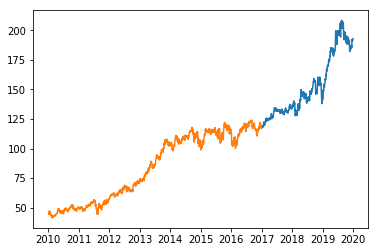

In [6]:
plt.plot(base_test)
plt.plot(base_train)
plt.show()

## Demonstrate Simple Vanilla Implementation

In [7]:
# Multi-step data preparation

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# define input sequence
#raw_seq = list(base_test[:100].values)
# choose a number of time steps
n_steps_in, n_steps_out = 30, 30
# split into samples
X_train, y_train = split_sequence(base_train.values, n_steps_in, n_steps_out)
X_test, y_test = split_sequence(base_test.values, n_steps_in, n_steps_out) #length must be > n_in + n_out
# summarize the data
#for i in range(len(X)):
#    print(X[i], y[i])
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1703, 30) (1703, 30) (695, 30) (695, 30)


In [8]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
#print (X_train.shape)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
#print (X_test.shape)

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

# fit model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, verbose=1, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 30)                3030      
Total params: 43,830
Trainable params: 43,830
Non-trainable params: 0
_________________________________________________________________

Train on 1703 samples, validate on 695 samples
Epoch 1/20
1703/1703 [==============================] - 2s 1ms/step - loss: 2059.3333 - val_loss: 412.4544
Epoch 2/20
1703/1703 [==============================] - 2s 1ms/step - loss: 72.2292 - val_loss: 240.3671
Epoch 3/20
1703/1703 [==============================] - 2s 1ms/step - loss: 42.3224 - val_loss: 220.4168
Epoch 4/20
1703/1703 [==============================] - 2s 1ms/step - loss: 34.5715 - val_loss: 121.0543
Epoch 5/20
1703/1703 [====================

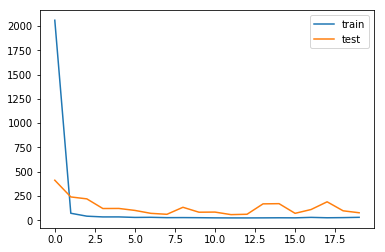

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Stacked LSTM 

In [10]:
#params for grid search

p = {'LSTM_n' : [100, 200, 400],
    'LSTM_dropout' : [0, 0.1, 0.2],
    'batch_size' : [30, 60, 90, 120],
}

In [11]:
def LSTM_model(X_train, y_train, X_test, y_test, params):
    model = Sequential()                            
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu', return_sequences=True))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(LSTM(params['LSTM_n'], activation='relu'))
    model.add(Dropout(params['LSTM_dropout']))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='Adam', 
                  loss='mse')
    print (model.summary())
    
    #Early Stopping to avoid wasting time on bad hyperparams
    es = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

    out = model.fit(X_train, y_train,
                    epochs=100,
                    verbose=1,
                    batch_size=params['batch_size'],
                    callbacks=[es],
                    validation_data=[X_test, y_test])
    
    return out, model

In [12]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

scan_object = talos.Scan(X_train,
                         y_train, 
                         params=p,
                         model=LSTM_model,
                         experiment_name='LSTM',
                         fraction_limit=0.5,
                         print_params=True)

  0%|          | 0/18 [00:00<?, ?it/s]

{'batch_size': 90, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 6s 5ms/step - loss: 7957.6405 - val_loss: 7979.6902
Epoch 56/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7956.6149 - val_loss: 7980.5473
Epoch 57/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7957.0607 - val_loss: 7980.1391
Epoch 58/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7956.1771 - val_loss: 7978.9897
Epoch 59/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7954.9646 - val_loss: 7977.7381
Epoch 60/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7953.6983 - val_loss: 7976.4539
Epoch 61/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7952.4006 - val_loss: 7975.1480
Epoch 62/100
1192/1192 [==============================] - 6s 5ms/step - loss: 7951.0899 - val_loss: 7973.8216
Epoch 63/100
1192/1192 [==============================] - 5s 5ms/step - loss: 7949.7531 - val_loss: 7972.4763
Epoch 64/100
1192/1192 

  6%|▌         | 1/18 [10:42<3:02:09, 642.89s/it]

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

1192/1192 [==============================] - 14s 12ms/step - loss: 26237.1305 - val_loss: 7696.0375
Epoch 55/100
1192/1192 [==============================] - 14s 12ms/step - loss: 25753.1415 - val_loss: 7689.5636
Epoch 56/100
1192/1192 [==============================] - 14s 12ms/step - loss: 23976.6359 - val_loss: 7683.1321
Epoch 57/100
1192/1192 [==============================] - 15s 13ms/step - loss: 9380.3711 - val_loss: 7676.6140
Epoch 58/100
1192/1192 [==============================] - 14s 11ms/step - loss: 11844.1911 - val_loss: 7670.0997
Epoch 59/100
1192/1192 [==============================] - 14s 12ms/step - loss: 7441.4535 - val_loss: 7291.3012
Epoch 60/100
1192/1192 [==============================] - 14s 12ms/step - loss: 16581.3006 - val_loss: 7637.9507
Epoch 61/100
1192/1192 [==============================] - 14s 12ms/step - loss: 7281.3631 - val_loss: 3953.8612
Epoch 62/100
1192/1192 [==============================] - 14s 12ms/step - loss: 3319.5119 - val_loss: 915.9646
E

 11%|█         | 2/18 [34:55<3:56:10, 885.67s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________

 17%|█▋        | 3/18 [40:55<3:02:01, 728.12s/it]

{'batch_size': 90, 'LSTM_n': 100, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________

 22%|██▏       | 4/18 [43:20<2:09:05, 553.24s/it]

{'batch_size': 90, 'LSTM_n': 400, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________

1192/1192 [==============================] - 17s 15ms/step - loss: 8415.0154 - val_loss: 8004.8019
Epoch 55/100
1192/1192 [==============================] - 21s 18ms/step - loss: 8012.2484 - val_loss: 8004.2567
Epoch 56/100
1192/1192 [==============================] - 19s 16ms/step - loss: 10836.1362 - val_loss: 8003.6576
Epoch 57/100
1192/1192 [==============================] - 20s 17ms/step - loss: 8050.6451 - val_loss: 8003.0405
Epoch 58/100
1192/1192 [==============================] - 20s 17ms/step - loss: 17030.8641 - val_loss: 8002.4216
Epoch 59/100
1192/1192 [==============================] - 20s 16ms/step - loss: 7978.8150 - val_loss: 8001.7883
Epoch 60/100
1192/1192 [==============================] - 20s 17ms/step - loss: 70812.0142 - val_loss: 8001.1470
Epoch 61/100
1192/1192 [==============================] - 20s 17ms/step - loss: 18424.7418 - val_loss: 8000.4971
Epoch 62/100
1192/1192 [==============================] - 20s 16ms/step - loss: 10843.9154 - val_loss: 7999.8387


 28%|██▊       | 5/18 [1:11:50<3:15:03, 900.25s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
l

 33%|███▎      | 6/18 [1:13:26<2:11:47, 658.93s/it]

{'batch_size': 120, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________


 39%|███▉      | 7/18 [1:15:17<1:30:39, 494.50s/it]

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 8s 7ms/step - loss: 7954.1591 - val_loss: 7976.9826
Epoch 56/100
1192/1192 [==============================] - 8s 7ms/step - loss: 7952.8069 - val_loss: 7975.4739
Epoch 57/100
1192/1192 [==============================] - 9s 7ms/step - loss: 7951.0634 - val_loss: 7973.4135
Epoch 58/100
1192/1192 [==============================] - 8s 7ms/step - loss: 7948.5434 - val_loss: 7970.2389
Epoch 59/100
1192/1192 [==============================] - 8s 7ms/step - loss: 7944.1191 - val_loss: 7963.7680
Epoch 60/100
1192/1192 [==============================] - 9s 8ms/step - loss: 7927.3105 - val_loss: 7865.1274
Epoch 61/100
1192/1192 [==============================] - 8s 7ms/step - loss: 2108635.1167 - val_loss: 7978.4241
Epoch 62/100
1192/1192 [==============================] - 8s 7ms/step - loss: 31189.6078 - val_loss: 7978.2899
Epoch 63/100
1192/1192 [==============================] - 8s 7ms/step - loss: 7954.5373 - val_loss: 7977.6863
Epoch 64/100
1192/1

 44%|████▍     | 8/18 [1:26:11<1:30:25, 542.50s/it]

{'batch_size': 60, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________

 50%|█████     | 9/18 [1:29:20<1:05:27, 436.41s/it]

{'batch_size': 120, 'LSTM_n': 100, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
________________________________________________________________

 56%|█████▌    | 10/18 [1:31:45<46:31, 348.92s/it] 

{'batch_size': 30, 'LSTM_n': 400, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 16s 14ms/step - loss: 8001.3502 - val_loss: 8024.7441
Epoch 54/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8001.2392 - val_loss: 8024.6341
Epoch 55/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8001.1323 - val_loss: 8024.5294
Epoch 56/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8001.0295 - val_loss: 8024.4284
Epoch 57/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8000.9302 - val_loss: 8024.3294
Epoch 58/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8000.8333 - val_loss: 8024.2347
Epoch 59/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8000.7392 - val_loss: 8024.1411
Epoch 60/100
1192/1192 [==============================] - 16s 14ms/step - loss: 8000.6467 - val_loss: 8024.0496
Epoch 61/100
1192/1192 [==============================] - 17s 14ms/step - loss: 8000.5561 - val_loss: 8023.9590
Epoch

 61%|██████    | 11/18 [1:49:55<1:06:39, 571.32s/it]

{'batch_size': 120, 'LSTM_n': 200, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
________________________________________________________________

 67%|██████▋   | 12/18 [1:51:45<43:17, 432.85s/it]  

{'batch_size': 90, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________

1192/1192 [==============================] - 9s 8ms/step - loss: 62143.9338 - val_loss: 8023.4072
Epoch 55/100
1192/1192 [==============================] - 9s 8ms/step - loss: 108618.2715 - val_loss: 8023.3583
Epoch 56/100
1192/1192 [==============================] - 9s 8ms/step - loss: 65036.5736 - val_loss: 8023.3020
Epoch 57/100
1192/1192 [==============================] - 9s 8ms/step - loss: 201445.9349 - val_loss: 8023.2236
Epoch 58/100
1192/1192 [==============================] - 10s 8ms/step - loss: 247238.6890 - val_loss: 8023.1597
Epoch 59/100
1192/1192 [==============================] - 9s 8ms/step - loss: 39260.8220 - val_loss: 8023.1147
Epoch 60/100
1192/1192 [==============================] - 10s 8ms/step - loss: 147764.6356 - val_loss: 8023.0433
Epoch 61/100
1192/1192 [==============================] - 10s 8ms/step - loss: 18704.6342 - val_loss: 8022.9848
Epoch 62/100
1192/1192 [==============================] - 10s 8ms/step - loss: 33726.7543 - val_loss: 8022.9240
Epoch 

 72%|███████▏  | 13/18 [2:07:41<49:09, 589.89s/it]

{'batch_size': 60, 'LSTM_n': 200, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
l

1192/1192 [==============================] - 5s 5ms/step - loss: 51.4362 - val_loss: 48.2278
Epoch 57/100
1192/1192 [==============================] - 6s 5ms/step - loss: 55.7123 - val_loss: 56.6698
Epoch 58/100
1192/1192 [==============================] - 5s 4ms/step - loss: 65.1638 - val_loss: 55.3695
Epoch 59/100
1192/1192 [==============================] - 5s 5ms/step - loss: 58.3448 - val_loss: 57.0742
Epoch 60/100
1192/1192 [==============================] - 5s 5ms/step - loss: 57.6916 - val_loss: 55.1110
Epoch 61/100
1192/1192 [==============================] - 5s 5ms/step - loss: 55.5989 - val_loss: 56.9386
Epoch 62/100
1192/1192 [==============================] - 5s 5ms/step - loss: 55.4725 - val_loss: 54.1989
Epoch 63/100
1192/1192 [==============================] - 6s 5ms/step - loss: 55.3409 - val_loss: 51.7983
Epoch 64/100
1192/1192 [==============================] - 6s 5ms/step - loss: 52.1976 - val_loss: 51.4351
Epoch 65/100
1192/1192 [==============================] - 6

 78%|███████▊  | 14/18 [2:17:07<38:50, 582.65s/it]

{'batch_size': 120, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________


1192/1192 [==============================] - 3s 2ms/step - loss: 78.5702 - val_loss: 76.0309
Epoch 57/100
1192/1192 [==============================] - 3s 2ms/step - loss: 77.4148 - val_loss: 70.2518
Epoch 58/100
1192/1192 [==============================] - 3s 2ms/step - loss: 75.6144 - val_loss: 70.8887
Epoch 59/100
1192/1192 [==============================] - 3s 2ms/step - loss: 75.8408 - val_loss: 71.2366


 83%|████████▎ | 15/18 [2:19:55<22:54, 458.20s/it]

{'batch_size': 30, 'LSTM_n': 400, 'LSTM_dropout': 0.2}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 400)           643200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 400)           1281600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 400)           0         
_________________________________________________________________

1192/1192 [==============================] - 17s 14ms/step - loss: 18622.9381 - val_loss: 8024.2324
Epoch 54/100
1192/1192 [==============================] - 17s 14ms/step - loss: 19052.0641 - val_loss: 8024.2005
Epoch 55/100
1192/1192 [==============================] - 17s 14ms/step - loss: 16836.3600 - val_loss: 8024.1681
Epoch 56/100
1192/1192 [==============================] - 17s 14ms/step - loss: 10839.6664 - val_loss: 8024.1349
Epoch 57/100
1192/1192 [==============================] - 17s 14ms/step - loss: 26831.3931 - val_loss: 8024.1010
Epoch 58/100
1192/1192 [==============================] - 17s 14ms/step - loss: 37299.1060 - val_loss: 8024.0660
Epoch 59/100
1192/1192 [==============================] - 17s 14ms/step - loss: 28666.8352 - val_loss: 8024.0303
Epoch 60/100
1192/1192 [==============================] - 17s 14ms/step - loss: 65083.4097 - val_loss: 8023.9934
Epoch 61/100
1192/1192 [==============================] - 17s 14ms/step - loss: 22940.6901 - val_loss: 8023.9

 89%|████████▉ | 16/18 [2:46:12<26:28, 794.02s/it]

{'batch_size': 90, 'LSTM_n': 100, 'LSTM_dropout': 0}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 100)           40800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 100)           80400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 100)           0         
_________________________________________________________________
l

 94%|█████████▍| 17/18 [2:48:32<09:57, 597.64s/it]

{'batch_size': 30, 'LSTM_n': 200, 'LSTM_dropout': 0.1}
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 200)           0         
_________________________________________________________________

100%|██████████| 18/18 [2:51:32<00:00, 571.80s/it]


There is a bug (link below) in the Talos library that means it sorts the columns and values from parameter dictionary incorrectly in the ```talos.Analze``` object. That is why each hyperparameter has unique values so I can easily understand the results.

[https://github.com/autonomio/talos/issues/439]

In [13]:
analyze_object = talos.Analyze(scan_object)
df = analyze_object.data
df.sort_values(by=['val_loss'])

,round_epochs,val_loss,loss,LSTM_dropout,LSTM_n,batch_size
16,53,27.232586,19.901883,90,100,0.0
13,100,33.399596,33.878929,60,200,0.0
14,59,71.236593,75.840805,120,100,0.0
9,53,114.846235,224.332397,120,100,0.2
8,48,254.929426,724.074489,60,100,0.2
2,54,256.996254,261.670937,60,100,0.1
17,23,7877.314776,9245.060340,30,200,0.1
0,100,7921.480580,7898.852284,90,200,0.0
7,80,7968.105866,7945.001771,30,200,0.0
3,24,7980.693736,9586.655944,90,100,0.1


### Results
* The top three results are interesting. They all feature:
  * 100 or 200 neurons in LSTM layers
  * No dropout for LSTM layers
  * Large batch size > 60